In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [2]:
import pandas as pd
import pandas_datareader.fred as fred
import numpy as np

from src.plotting import plot_dfs, all_equal
from src.process_data import get_fred_data, ser_adf, get_seasonal_hp
from src.classes import PolyDetrend
from src.utils import apply_func

import seaborn as sns

import datetime as dt

Load data

In [3]:
from config import recession_dict
df_all = pd.read_csv(os.path.join(DATA_DIR, 'raw_data.csv'), index_col='date').drop('Unnamed: 0', axis=1)
df_all.index = pd.to_datetime(df_all.index)
df_all = df_all.asfreq('QS')

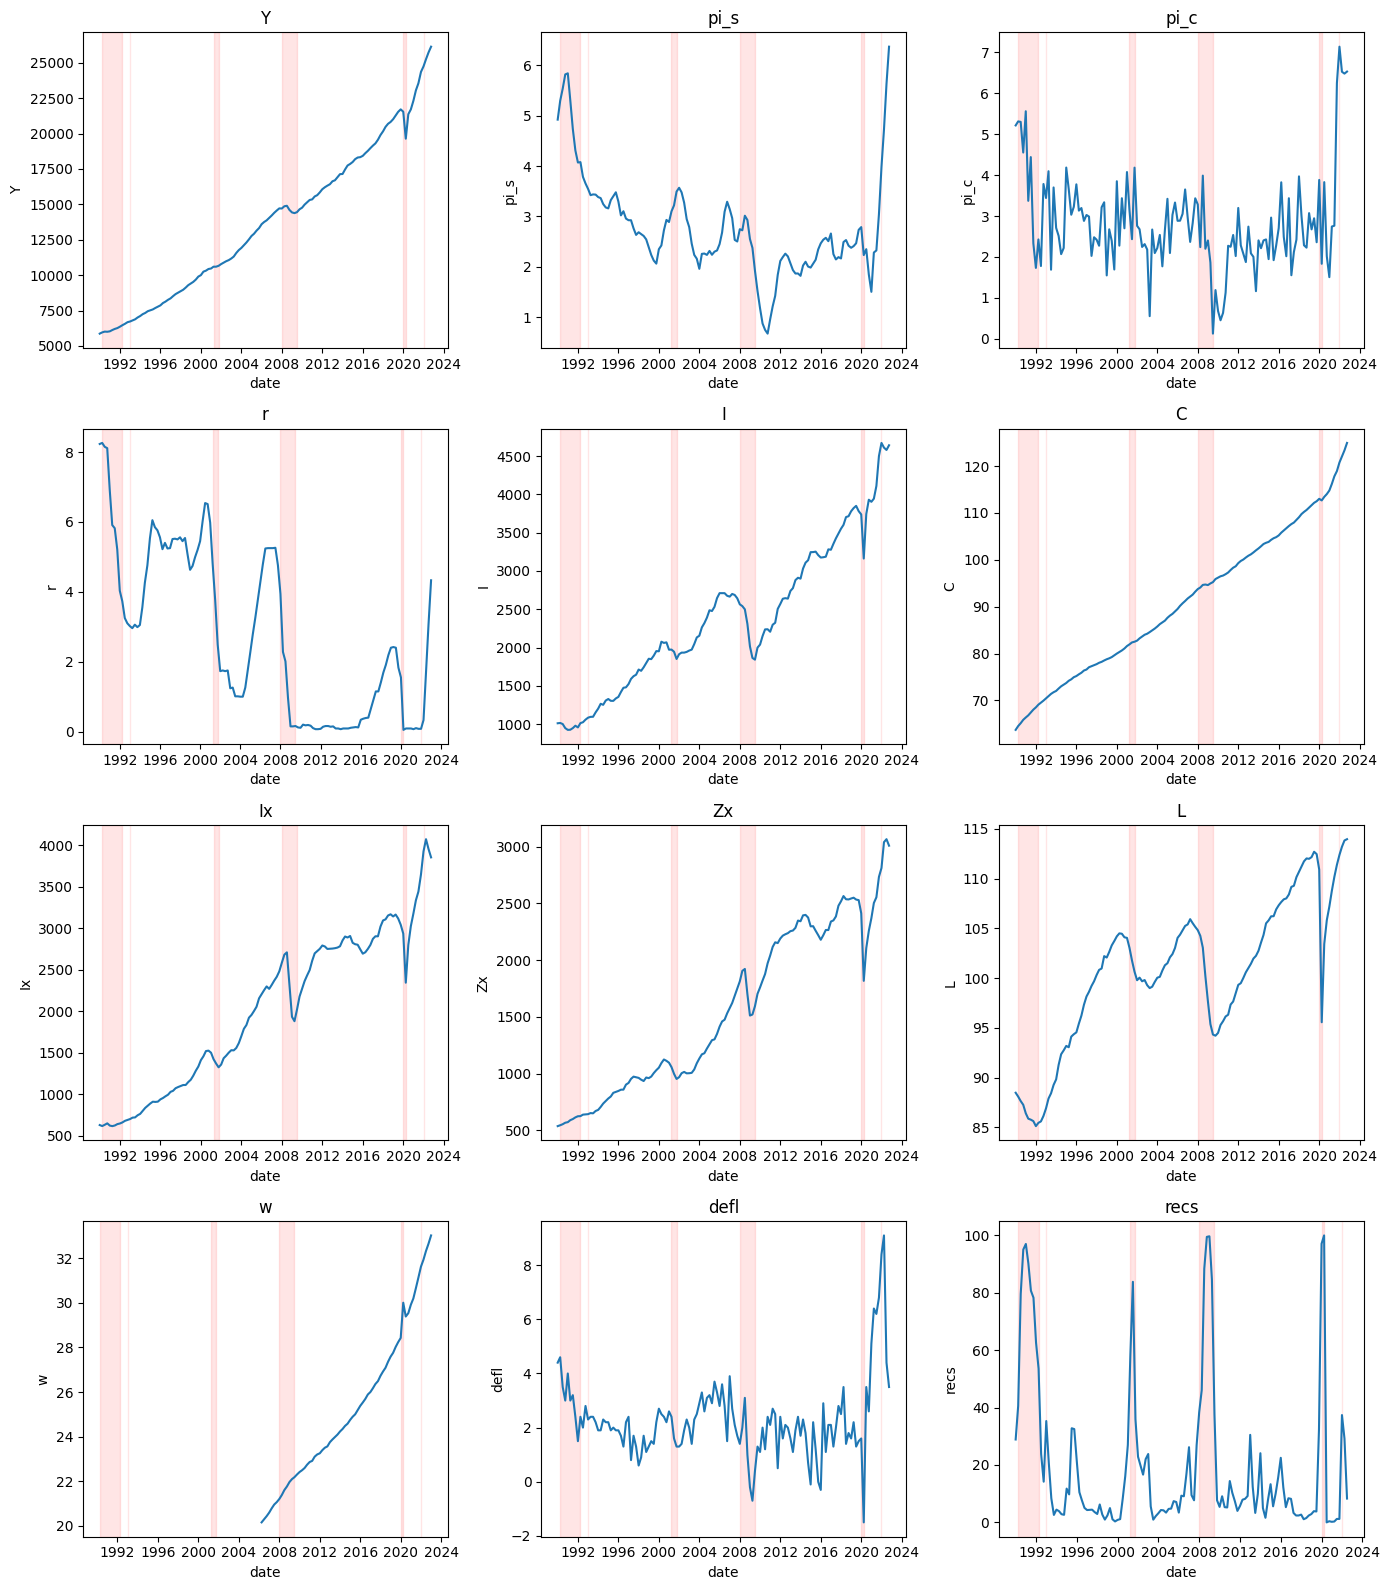

In [4]:
plot_dfs(df_all, sns.lineplot, fill_arr=recession_dict)

work data

In [5]:
df = df_all.dropna().copy()
df.drop(['recs', 'defl'], axis=1, inplace=True)

# sample period
print(f'sample starts: {df.index[0].date()} \nsample ends: {df.index[-1].date()}')

# check for missing intra sample data
pd.DataFrame(df.index - df.index.shift(-1)).describe()

sample starts: 2006-04-01 
sample ends: 2022-07-01


,date
count,66
mean,91 days 06:54:32.727272727
std,0 days 18:42:58.623739751
min,90 days 00:00:00
25%,91 days 00:00:00
50%,91 days 00:00:00
75%,92 days 00:00:00
max,92 days 00:00:00


In [6]:
# train test split
test_size = .2
test_ind = df.iloc[-round(len(df) * test_size):,:].index
train_ind = df.iloc[:-round(len(df) * test_size),:].index

In [7]:
print(f'test size is: {test_size * 100}%, corresponding to {len(test_ind)} lines')
print(f'time between train & test: {(train_ind[-1] - test_ind[0])}')

test size is: 20.0%, corresponding to 13 lines
time between train & test: -91 days +00:00:00


log trans

In [8]:
non_neg = [col for col in df.columns if min(df[col]) > 0]
print(f'All cols non-negative: {all_equal([non_neg, list(df.columns)])}')
for col in non_neg:
    df[col] = apply_func(df[col], np.log1p)

All cols non-negative: True


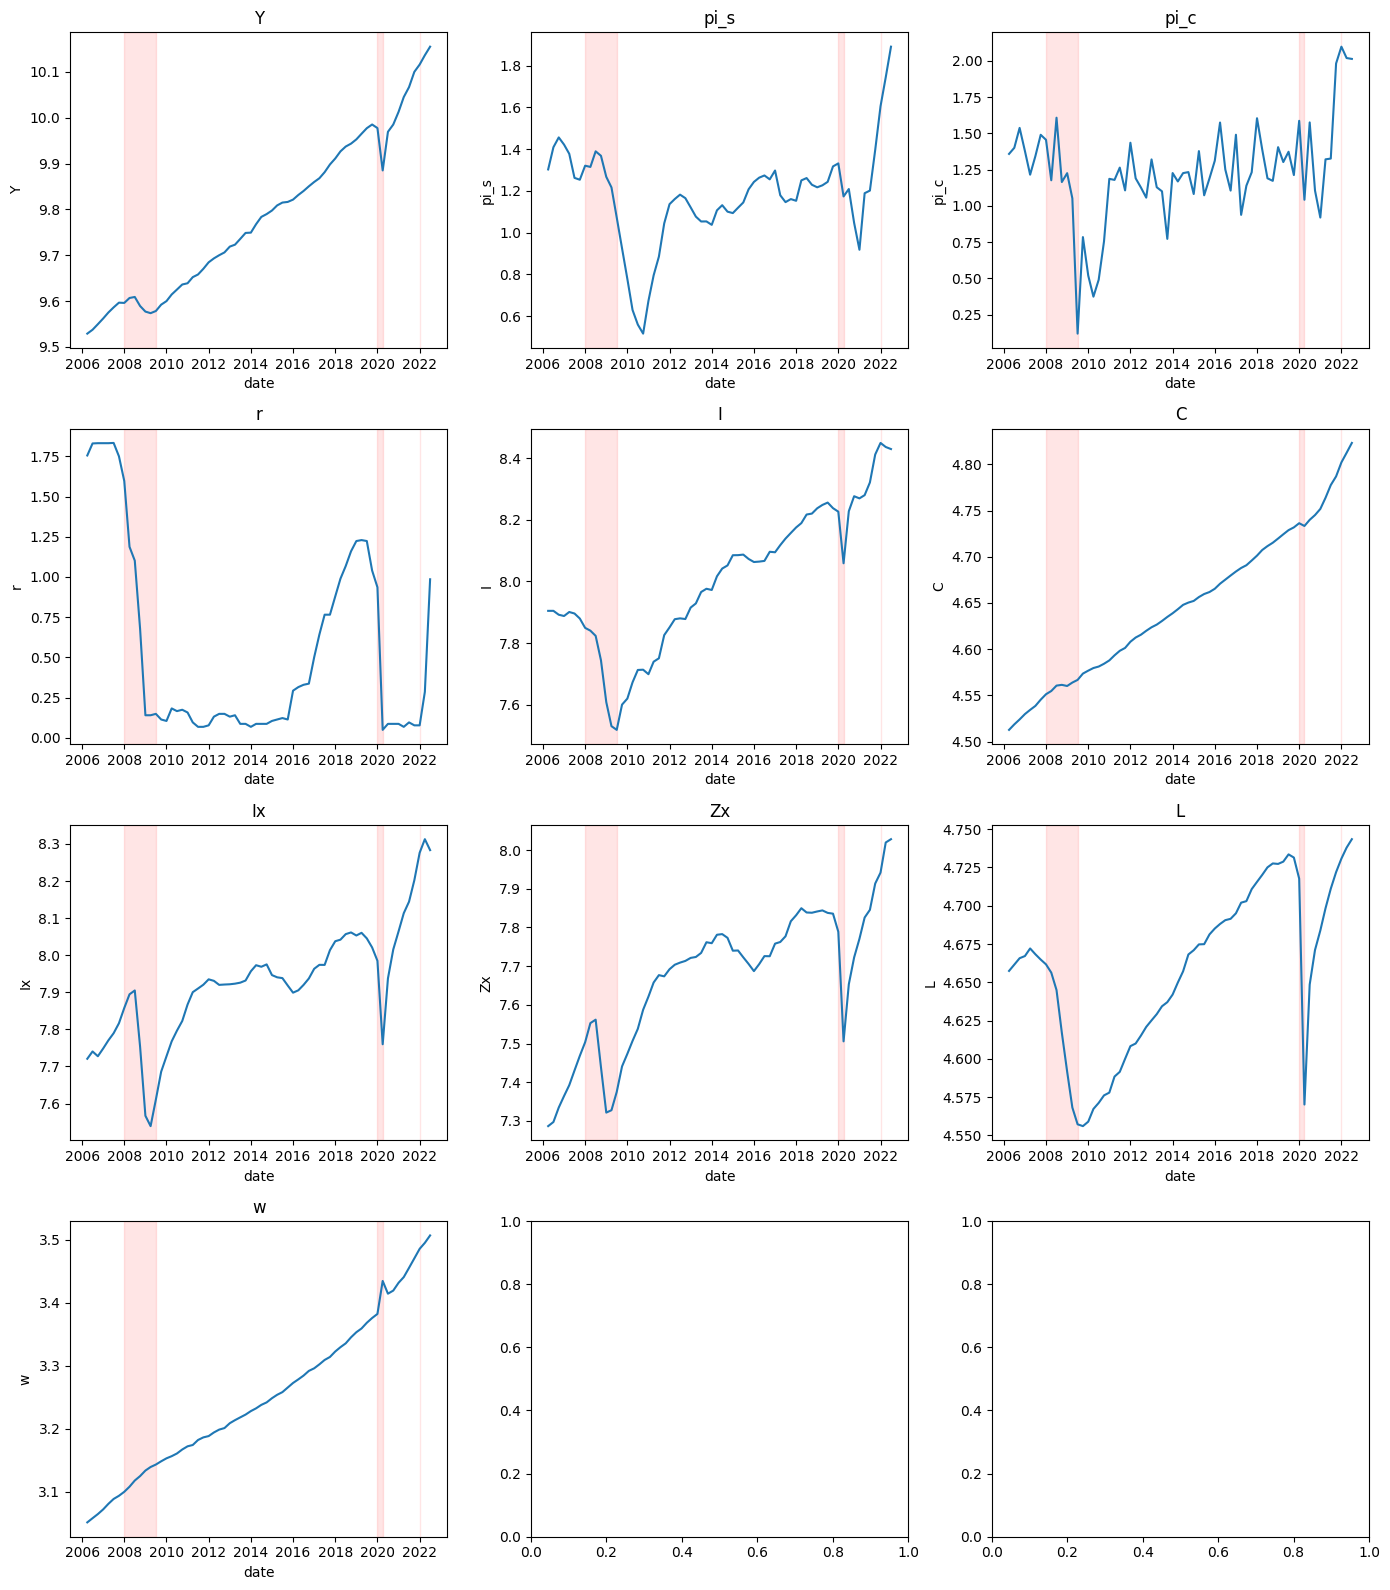

In [9]:
plot_dfs(df, sns.lineplot, fill_arr=recession_dict)

test stationarity

In [10]:
# for col in df.columns:
#     ser_adf(df.loc[train_ind, col])

polynomial detrend

In [11]:
df_1 = df.copy()
df_2 = df.copy()

In [12]:
# poly detrend
detrend_cols = ["Y", "I", "C", "L", "Ix", "Zx", "w"]
for col in detrend_cols:
    _train = df_1.loc[train_ind, col].copy()
    _det = PolyDetrend(_train, 2)
    df_1.loc[train_ind, col] = _det.get_detrend()
    
    _test = df_1.loc[test_ind, col].copy()
    df_1.loc[test_ind, col] = _det.predict_detrend(_test)

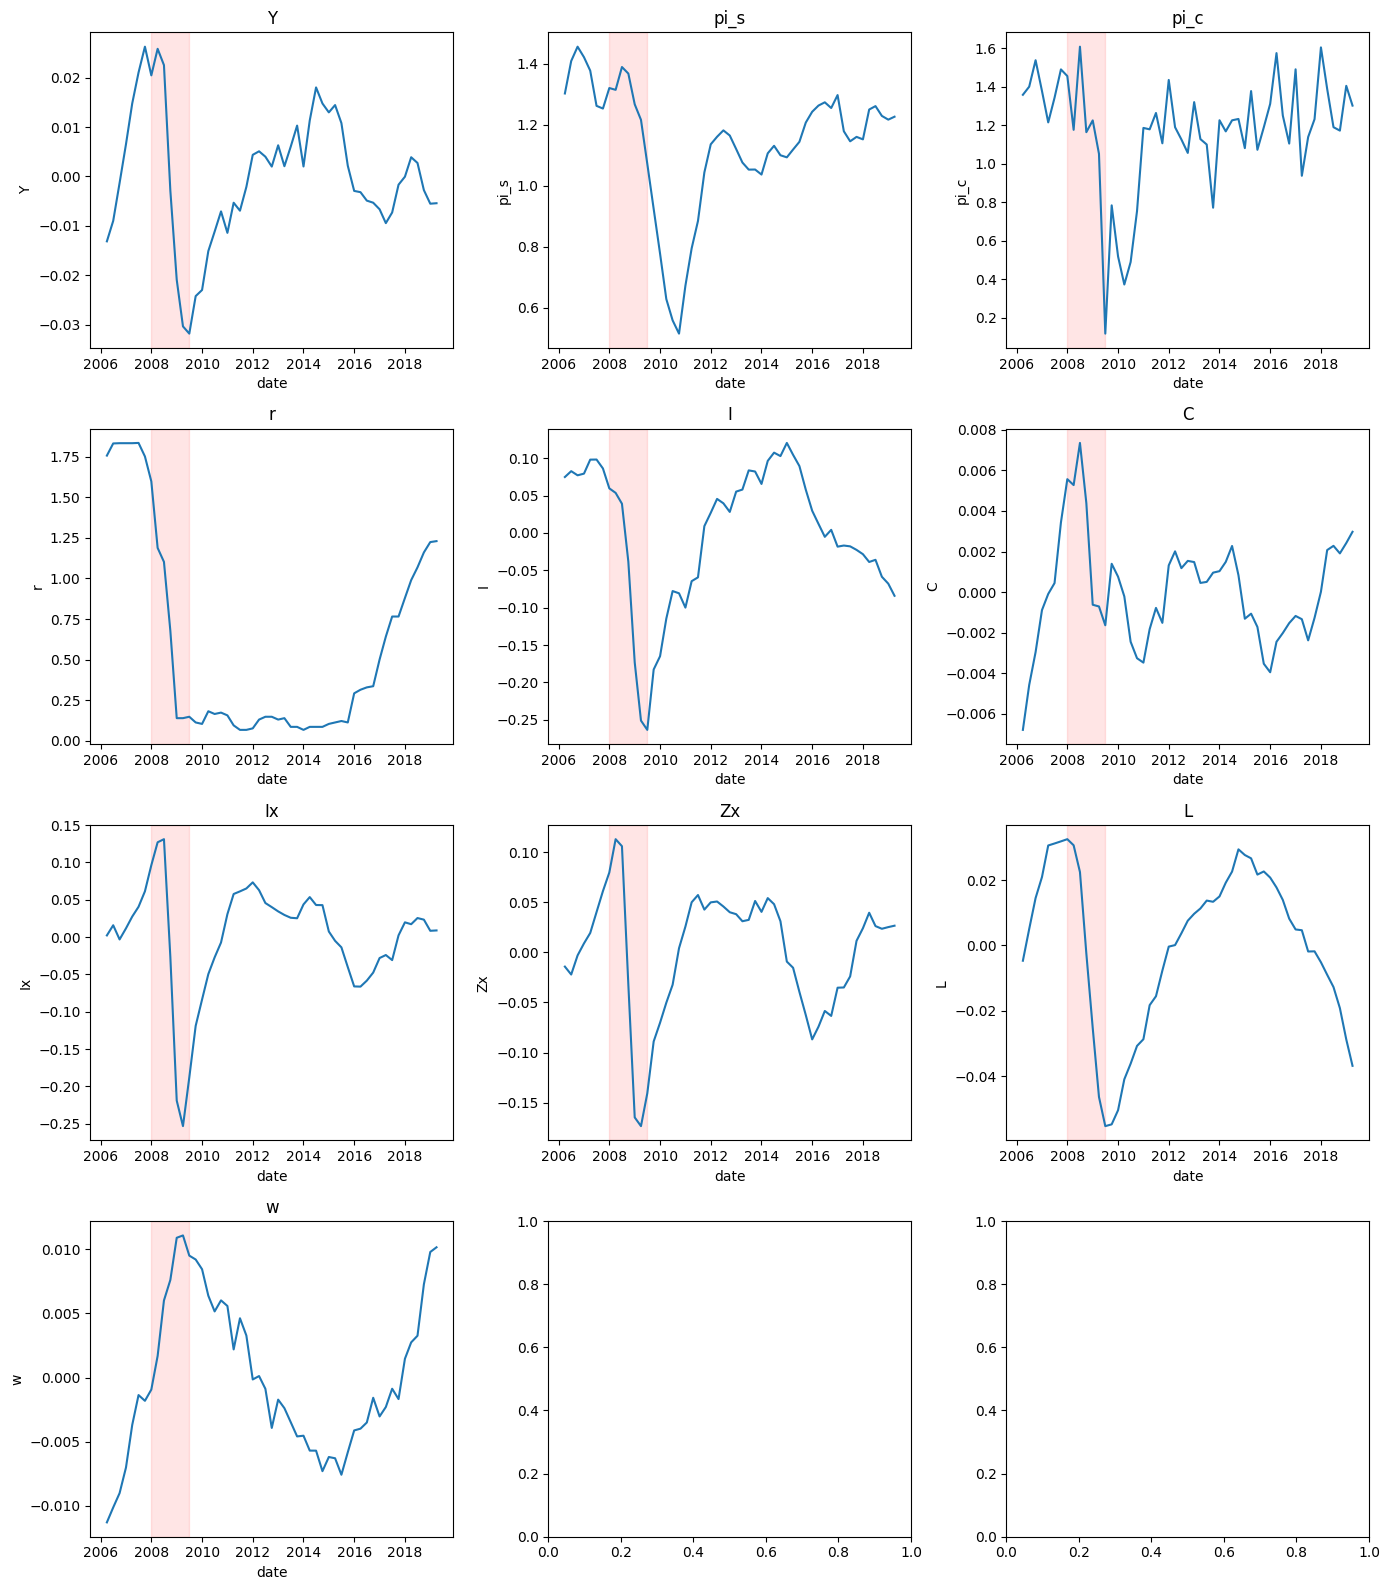

In [13]:
plot_dfs(df_1.loc[train_ind], sns.lineplot, fill_arr=recession_dict)

In [14]:
# hp detrend
detrend_cols = ["Y", "I", "C", "L", "Ix", "Zx", "w"]
for col in detrend_cols:
    _ser = df_2[col].copy()
    _cyc, _det = get_seasonal_hp(_ser)
    df_2[col] = _cyc

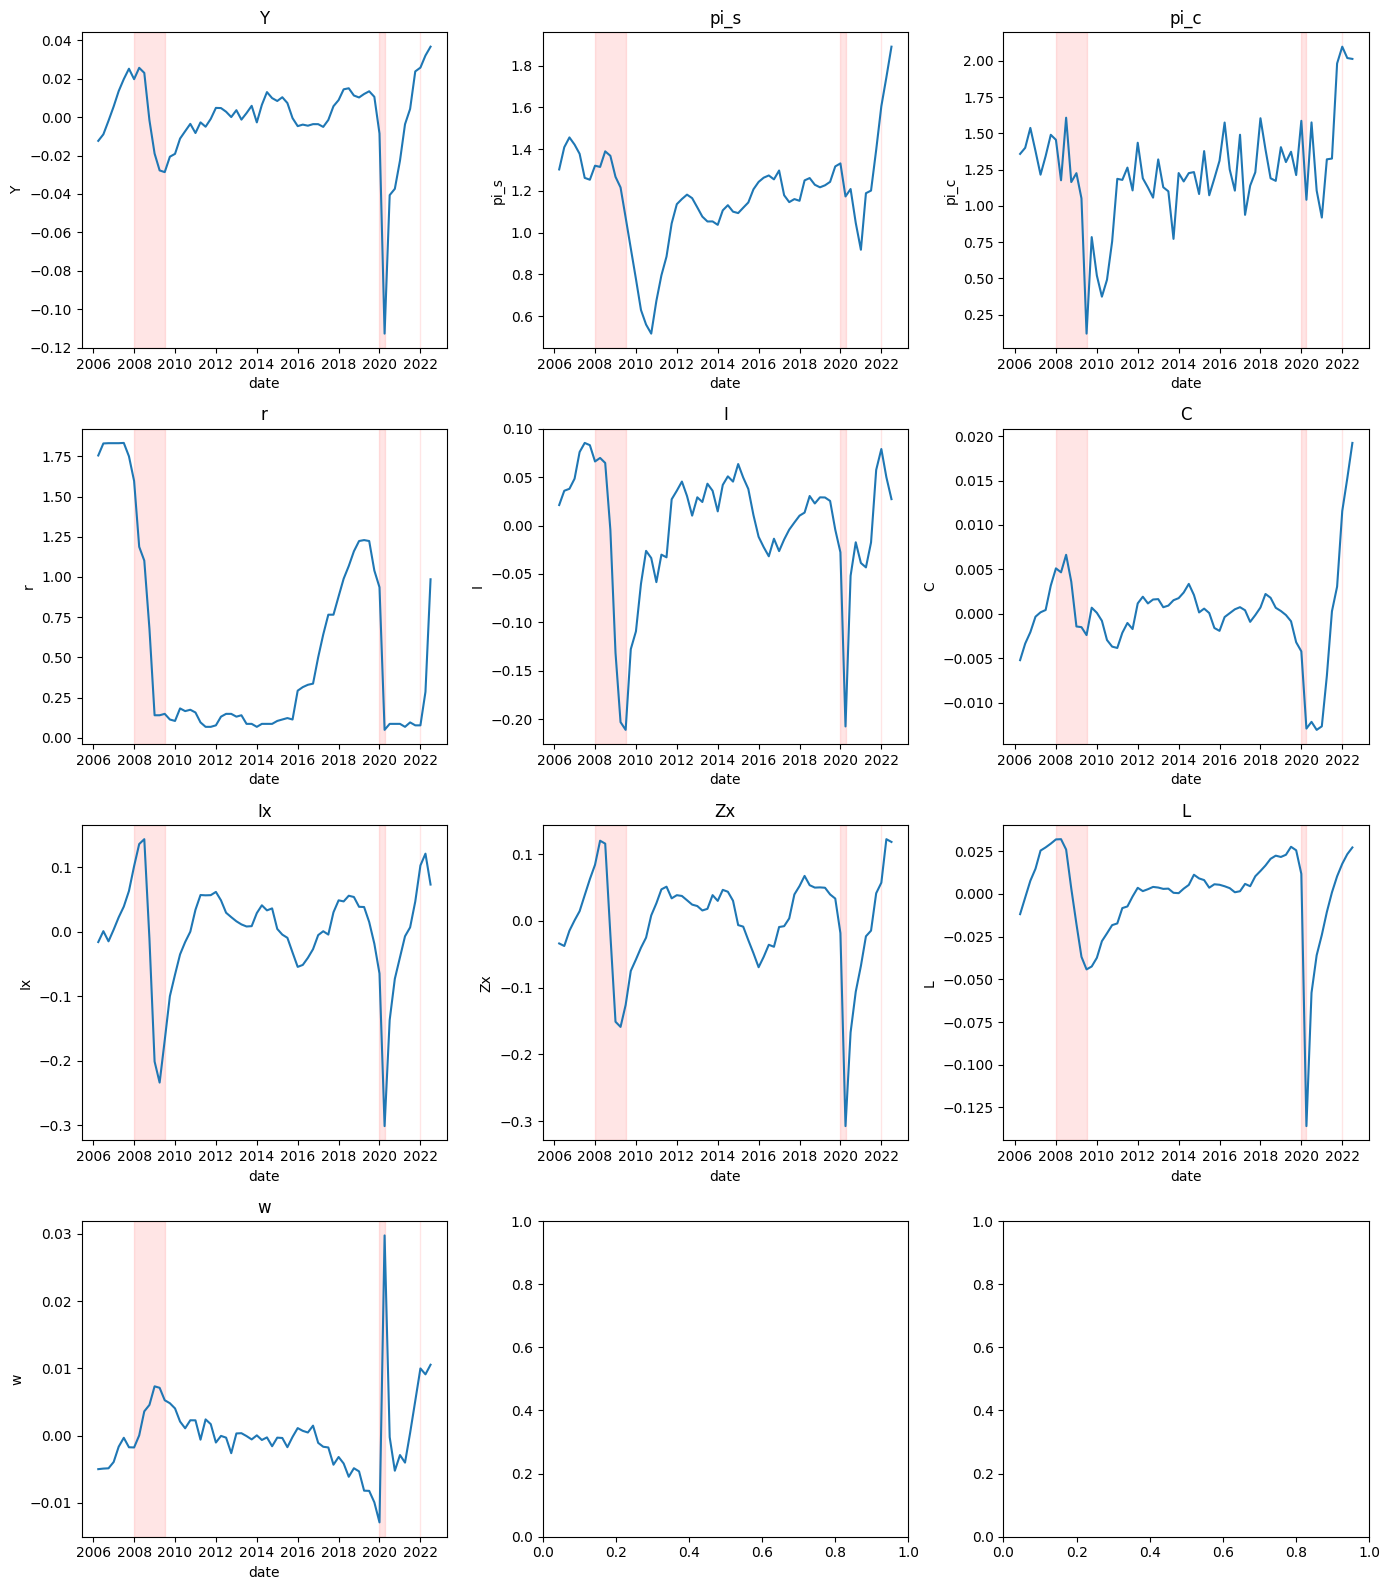

In [15]:
plot_dfs(df_2, sns.lineplot, fill_arr=recession_dict)

stationarity

In [16]:
# train data poly detrend
for col in df_1.columns:
    ser_adf(df_1.loc[train_ind, col])

Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- Y --------------------
 p-val: 0.031739829109460535,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- pi_s --------------------
 p-val: 0.3915433149080645,  reject: False


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- pi_c --------------------
 p-val: 0.0028223185239208627,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- r --------------------
 p-val: 0.05314799754667645,  reject: False


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- I --------------------
 p-val: 0.14848703007275998,  reject: False


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- C --------------------
 p-val: 0.02162567096426803,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- Ix --------------------
 p-val: 0.030493290576966318,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit r

In [17]:
# train data hp filter
for col in df_2.columns:
    ser_adf(df_2.loc[train_ind, col])

Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- Y --------------------
 p-val: 0.024650253429796376,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- pi_s --------------------
 p-val: 0.3915433149080645,  reject: False


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- pi_c --------------------
 p-val: 0.0028223185239208627,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- r --------------------
 p-val: 0.05314799754667645,  reject: False


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- I --------------------
 p-val: 0.025896738157116322,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- C --------------------
 p-val: 0.006314467796114257,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- Ix --------------------
 p-val: 0.016606504434308524,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit 

save data

In [18]:
df_2['is_test'] = list([False] * len(df_2))
df_2.loc[test_ind, 'is_test'] = list([True] * len(test_ind))

In [19]:
df_2.reset_index(names='date').to_csv(os.path.join(DATA_DIR, 'prepro_data.csv'))